In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL  import Image, ImageOps
import time

### Dataset Loader

#### Data Augmentation

In [2]:
class ToTorch(object):
    def __call__(self, sample):
        image , label = sample['image'], sample['label']
        image = image.resize((120,120), Image.ANTIALIAS)
        image = np.array(image)
        image = image.transpose((2,0,1))
        return {'image': torch.from_numpy(image), 'label': torch.from_numpy(np.array([label]))}

In [3]:
class roi(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        size = (random.randint(120,240),random.randint(120,240))
        image = image.resize(size, Image.ANTIALIAS)
        size = image.size
        if size[0]>=120:
            width = random.randint(120, size[0])
        else:
            width = size[0]
        if size[1]>=120:
            height = random.randint(120, size[1])
        else:
            height = size[1]
        x = random.randint(0,size[0]-width)
        y = random.randint(0, size[1]-height)
        image = image.crop((x,y,x+width, y+height))
        return {'image': image, 'label': label}

In [4]:
class flip(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if random.randint(1,100)< 10:
            image = ImageOps.flip(image)
        return {'image': image, 'label': label}

In [5]:
class mirror(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if random.randint(0,1)== 1:
            image = ImageOps.mirror(image)
        return {'image': image, 'label': label}

#### DataSet Class

In [6]:
class CatDogDataset(Dataset):
    
    def __init__(self, root_dir, csv,  transform=None, isval=False):
        self.root_dir = root_dir
        self.transform = transform
        if isval==True:
            self.val_size = 2000
        if(os.path.exists(csv)):
            self.csv = pd.read_csv(csv, header=None)
            if isval==True:
                self.csv = self.csv[:self.val_size]
            print("Found the csv!!..")
        else:
            self.create(csv)
            print("Not Found the csv!!..")
        #print(self.csv)
            
    def create(self, csv_path):
        dataset = np.array([])
        classes = os.listdir(self.root_dir)
        self.csv = []
        for i in range(len(classes)):
            self.csv.extend([[os.path.join(classes[i],j), i]for j in os.listdir(os.path.join(self.root_dir, classes[i]))])
        random.shuffle(self.csv)
        self.csv = pd.DataFrame(self.csv)
        self.csv.to_csv(csv_path, index=False, header = False)
    
    def numcatdog(self):
        count=0
        for i in range(len(self.csv)):
            if self.csv.iloc[i,1]==1:
                count +=1
        return count
    
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_name = os.path.join(self.root_dir, self.csv.iloc[index, 0])
        image_label = self.csv.iloc[index, 1]
        image = Image.open(image_name)
        sample = {'image':image, 'label':image_label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [7]:
compose = transforms.Compose([roi(), mirror(), ToTorch()])
trainset = CatDogDataset(r'dataset\augmentation_set\augmentation_image',
                         r'dataset\augmentation_set\augmentation.csv', ToTorch())
valset = CatDogDataset(r'dataset\test_set', r'dataset\test_set\test_data.csv', ToTorch(), True)
print("Training set len: ", len(trainset))
print("Val set len: ", len(valset))

Found the csv!!..
Found the csv!!..
Training set len:  56000
Val set len:  2000


In [8]:
print("Train set:")
count = trainset.numcatdog()
print("Dogs: ",count,"Cats: ", len(trainset)-count)
print("Validation set:")
count = valset.numcatdog()
print("Dogs: ",count,"Cats: ", len(valset)-count)
del(count)

Train set:
Dogs:  28000 Cats:  28000
Validation set:
Dogs:  1000 Cats:  1000


Length:  56000
Image length:  (3, 120, 120)
Label: 1 tensor([1])


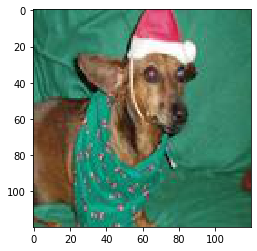

In [9]:
index = 000
t = time.time()
sample = trainset[index]
print('Length: ',len(trainset))
print('Image length: ',sample['image'].numpy().shape)
plt.imshow(sample['image'].numpy().transpose((1,2,0)))
print('Label:', int(sample['label']), sample['label'])

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.batch1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        
        #self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.batch2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)
        
        #self.dropout2 = nn.Dropout(0.1)
        
        self.conv3 = nn.Conv2d(64, 128 , 3)
        self.batch3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, stride=2)
        
        #self.dropout3 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(13*13*128, 128)
        self.relu_fc1 = nn.ReLU()
        self.batch_fc1 = nn.BatchNorm1d(128)            #Not In previous model
        
        #self.dropout4 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 80)
        self.relu_fc2 = nn.ReLU()
        self.batch_fc2 = nn.BatchNorm1d(80)            #Not In previous model
        
        #self.dropout5 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(80, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, choice=0):
        x = x/225
        x = self.conv1(x)
        x = self.pool1(self.batch1(self.relu1(x)))

        #x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.pool2(self.batch2(self.relu2(x)))
        
        #x = self.dropout2(x)

        x = self.conv3(x)
        x = self.pool3(self.batch3(self.relu3(x)))
        
        #x = self.dropout3(x)

        #print(x.shape)
        x = x.view(-1, 13*13*128)
        x = self.batch_fc1(self.relu_fc1(self.fc1(x)))

        #x = self.dropout4(x)
        
        x = self.batch_fc2(self.relu_fc2(self.fc2(x)))
        

        #x = self.dropout5(x)
            
        x = self.sigmoid(self.fc3(x))
        
        return x

In [11]:
model = Net().cuda()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21632, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (batch_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_featu

In [22]:
#for name, parameters in model.named_parameters():
#    print(name, parameters, parameters.grad_fn)
model.fc3   

Linear(in_features=80, out_features=1, bias=True)

In [ ]:
epoc = 20
criteria = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
trainloader = DataLoader(trainset, batch_size=80, shuffle = True)
valloader = DataLoader(valset, batch_size=80)

print("Starting training!!..\/")
t = time.time()


for i in range(epoc):
    cost = 0.0
    total_cost = 0.0
    size = 0
    for i_batch, sample in enumerate(trainloader):
        model.train()
        x_train = sample['image'].float().cuda()
        y_train = sample['label'].float().cuda()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criteria(output, y_train)
        loss.backward()
        optimizer.step()
        cost += loss.item()
        total_cost += loss.item()
        size += 1
        if(i_batch%20==19):
            print('[ Epoch: %3d, Mini_Batch:  %4d]     Loss %.3f'%(i+1, i_batch+1, cost/size), end='\r')
            cost = 0.0
            size = 0
    val_cost = 0.0
    for v_batch, sample in enumerate(valloader):
        model.eval()
        x_train = sample['image'].float().cuda()
        y_train = sample['label'].float().cuda()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criteria(output, y_train)
        val_cost += loss.item()
    print('[ Epoch: %3d ]   Training Loss: %.3f  Val Loss: %.3f'%(i+1, total_cost/(i_batch+1), val_cost/(v_batch+1)))

print("Finished Training!!!...")
print("Time taken: %.4f min...\n"%((time.time()-t)/60))

Starting training!!..\/
[ Epoch:   1 ]   Training Loss: 0.123  Val Loss: 0.229
[ Epoch:   2 ]   Training Loss: 0.071  Val Loss: 0.256


##  Accuracy Reading

In [43]:
check_train = CatDogDataset(r'dataset\training_set', r'dataset\training_set\training_data.csv', ToTorch())
check_test = CatDogDataset(r'dataset\test_set', r'dataset\test_set\test_data.csv', ToTorch())

check_dataloader = DataLoader(trainset, batch_size=80)
test_data = DataLoader(check_test, batch_size=80)

model.eval()
correct = 0
size = 0
for _, sample in enumerate(check_dataloader):
    y_predict = model(sample['image'].float().cuda())
    y_predict = (y_predict.cpu()>0.5).float()
    correct += torch.sum(torch.abs(y_predict-sample['label'].float()))
    size += len(y_predict)
    
train_acc = 100-100*correct/size
print("Train Accuracy for %5d images: %.2f %%"%(size, train_acc))

model.eval()
correct = 0
size = 0
for _, sample in enumerate(test_data):
    y_predict = model(sample['image'].float().cuda())
    y_predict = (y_predict.cpu()>0.5).float()
    correct += torch.sum(torch.abs(y_predict-sample['label'].float()))
    size += len(y_predict)
    
test_acc = 100-100*correct/size
print("Test Accuracy for %5d images: %.2f %%"%(size, test_acc))

Found the csv!!..
Found the csv!!..
Train Accuracy for 56000 images: 96.35 %
Test Accuracy for  2000 images: 92.80 %


In [78]:
import winsound

winsound.Beep(455, 1800)

## Inspect images with low accuracy

In [35]:
check_test = CatDogDataset(r'dataset\test_set', 'test_data.csv', ToTorch())
test_data = DataLoader(check_test, batch_size=1)
error_image = np.array([])
error_label = np.array([])
model.eval()
for i_batch, sample in enumerate(test_data):
    y_predict = model(sample['image'].float().cuda())
    y_predict = (y_predict.cpu()>0.5).float()
    if(y_predict!=sample['label'].float()):
        if len(error_image)==0:
            error_image = sample['image'].numpy()
            error_label = sample['label'].numpy()
        else:
            error_image = np.append(error_image, sample['image'].numpy(), axis=0)
            error_label = np.append(error_label, sample['label'].numpy(), axis=0)

Found the csv!!..


0


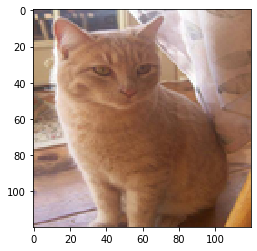

In [57]:
index = 142
plt.imshow(error_image[index].transpose((1,2,0)))
print(int(error_label[index]))

## Write a model

In [30]:
name = 'Model_new_v4'

path = os.path.join('Model', name)

os.mkdir(path)

torch.save(model.state_dict(), os.path.join(path, name))

log = ''

with open(os.path.join(path, 'Remarks.txt'), 'w') as f:
    f.write("\n\n *******************Model Details******************** \n\n")
    
    f.write('Train Accuracy: %d%%\n Test Accuracy: %d%%\n'%(train_acc, test_acc))
    c= ''
    f.write('\n Parameters: \n\n')
    for par in model.state_dict():
        c += str(par)+'\t'+str(model.state_dict()[par].size())+'\n'
        
    f.write(c)
    
    f.write("\nLast Loss: %.4f"%(loss.item()))
    f.write('\n\n'+log)

## Reading model

In [39]:
model = Net().cuda()
model.load_state_dict(torch.load(r'Model\Model_new_v4\Model_new_v4'))
model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21632, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (batch_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_featu